# Prediksi Volume Lalu Lintas Menggunakan Time Series Forecasting pada Data Metro Interstate Traffic
Minnesota Department of Transportation.
- Dataset: https://www.kaggle.com/datasets/fekihmea/metro-interstate-traffic-volume/data

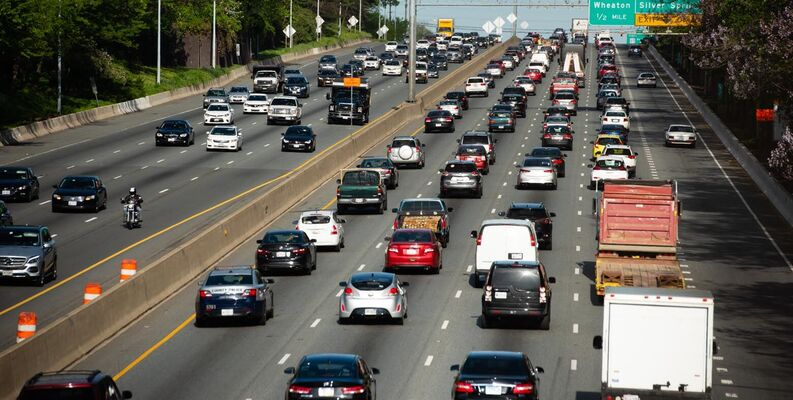

## Import Library

import library yang dibutuhkan seperti `pandas`, `numpy`, `matplotlib`, `seaborn`, serta library dari `TensorFlow` untuk membangun model LSTM.

In [ ]:
# Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tensorflow.keras.models import load_model
import pickle
import datetime

import warnings
warnings.filterwarnings('ignore')

# For modeling
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

# For LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

## Load Dataset

Dataset 'Metro Interstate Traffic Volume' dimuat dari file CSV. Dataset ini mencatat volume lalu lintas per jam serta informasi terkait waktu dan kondisi cuaca.

In [ ]:
# Load Dataset
file_path = '/content/drive/MyDrive/Colab Notebooks/DBS Coding Camp 2025/MLT/Metro_Interstate_Traffic_Volume.csv'
df = pd.read_csv(file_path)
df['date_time'] = pd.to_datetime(df['date_time'])
df = df.set_index('date_time')
df = df.sort_index()
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2012-10-02 09:00:00,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,5545
2012-10-02 10:00:00,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,4516
2012-10-02 11:00:00,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,4767
2012-10-02 12:00:00,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,5026
2012-10-02 13:00:00,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,4918


Fitur:

- holiday: libur nasional atau tidak
- temp: suhu dalam Kelvin
- rain_1h: curah hujan (mm)
- snow_1h: curah salju (mm)
- clouds_all: persentase awan
- weather_main: kategori cuaca
- weather_description: deskripsi cuaca
- date_time: timestamp (resolusi per jam)
- traffic_volume: target (jumlah kendaraan per jam)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48204 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              61 non-null     object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 3.3+ MB


In [ ]:
print(df['holiday'].value_counts())

holiday
Labor Day                    7
Christmas Day                6
Thanksgiving Day             6
Martin Luther King Jr Day    6
New Years Day                6
Veterans Day                 5
Columbus Day                 5
Memorial Day                 5
Washingtons Birthday         5
State Fair                   5
Independence Day             5
Name: count, dtype: int64


## Feature Engineering

Melakukan rekayasa fitur untuk mengubah suhu dari Kelvin ke Celcius, mengekstrak fitur waktu (jam, hari dalam seminggu), dan mengklasifikasikan akhir pekan. Fitur kategorikal seperti cuaca dan hari libur diubah menjadi representasi numerik dengan One-Hot Encoding.

In [ ]:
# suhu kelvin menjadi satuan celcius
df['temp'] = df['temp'] - 273.15

# Feature Engineering Extract time features
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['is_weekend'] = df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

In [ ]:
# One-hot encoding
df = pd.get_dummies(df, columns=['weather_main', 'holiday'], drop_first=True)

In [ ]:
df.tail()

,temp,rain_1h,snow_1h,clouds_all,weather_description,traffic_volume,hour,dayofweek,is_weekend,weather_main_Clouds,...,holiday_Columbus Day,holiday_Independence Day,holiday_Labor Day,holiday_Martin Luther King Jr Day,holiday_Memorial Day,holiday_New Years Day,holiday_State Fair,holiday_Thanksgiving Day,holiday_Veterans Day,holiday_Washingtons Birthday
date_time,,,,,,,,,,,,,,,,,,,,,
2018-09-30 19:00:00,10.30,0.0,0.0,75,broken clouds,3543,19,6,1,True,...,False,False,False,False,False,False,False,False,False,False
2018-09-30 20:00:00,9.61,0.0,0.0,90,overcast clouds,2781,20,6,1,True,...,False,False,False,False,False,False,False,False,False,False
2018-09-30 21:00:00,9.58,0.0,0.0,90,proximity thunderstorm,2159,21,6,1,False,...,False,False,False,False,False,False,False,False,False,False
2018-09-30 22:00:00,8.94,0.0,0.0,90,overcast clouds,1450,22,6,1,True,...,False,False,False,False,False,False,False,False,False,False
2018-09-30 23:00:00,8.97,0.0,0.0,90,overcast clouds,954,23,6,1,True,...,False,False,False,False,False,False,False,False,False,False


## Exploratory Data Analysis (EDA)
Visualisasi tren volume lalu lintas dari waktu ke waktu untuk memahami pola umum. Heatmap korelasi ditampilkan untuk mengetahui hubungan antar variabel numerik.

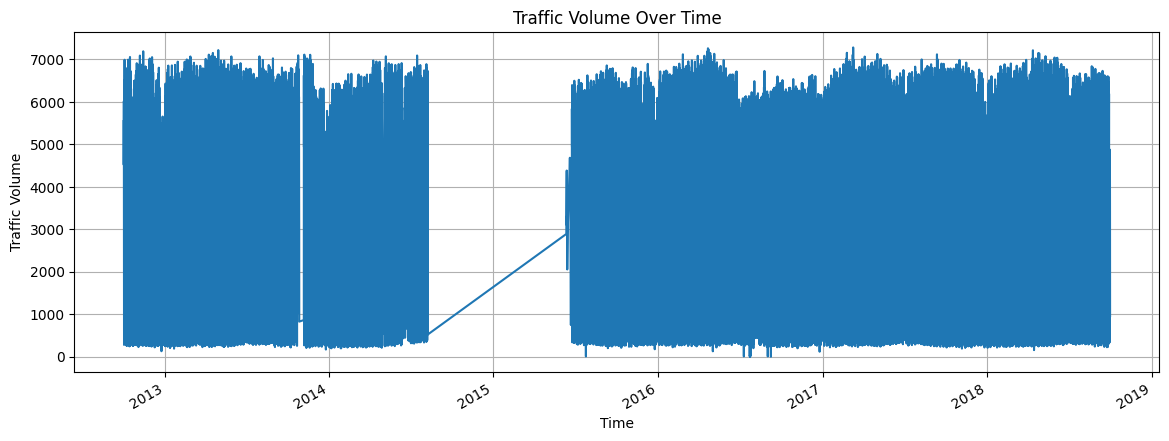

In [ ]:
# Exploratory Data Analysis
plt.figure(figsize=(14,5))
df['traffic_volume'].plot(title='Traffic Volume Over Time')
plt.xlabel('Time')
plt.ylabel('Traffic Volume')
plt.grid(True)
plt.show()

Grafik berikut menunjukkan tren volume lalu lintas dari tahun 2012 hingga 2018. Tujuan dari visualisasi ini adalah untuk melihat pola umum dan kelengkapan data seiring waktu. Setiap titik pada sumbu Y mewakili jumlah kendaraan per jam. Dari grafik terlihat bahwa terdapat beberapa bagian data yang hilang atau tidak tercatat, terutama pada tahun 2014 dan 2015 yang menunjukkan jeda panjang. Hal ini perlu menjadi perhatian karena dapat mempengaruhi proses training model. Secara umum, volume lalu lintas menunjukkan pola stabil dengan fluktuasi harian yang wajar, meskipun tampak ada noise atau outlier di beberapa titik (volume sangat rendah atau sangat tinggi).

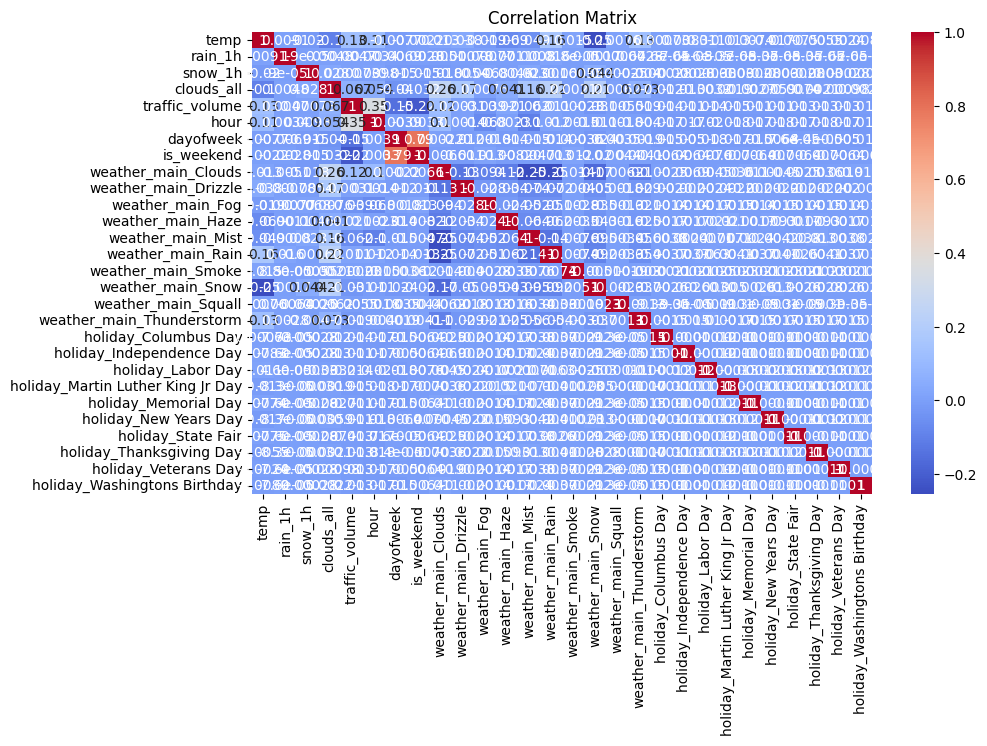

In [ ]:
# Heatmap korelasi antara cuaca dan volume
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Heatmap berikut menunjukkan korelasi antara fitur numerik dan fitur hasil one-hot encoding cuaca dan hari libur terhadap traffic_volume. Korelasi dihitung untuk memahami hubungan antara variabel dan membantu dalam pemilihan fitur untuk pemodelan. Dari matriks korelasi terlihat bahwa fitur hour memiliki korelasi tertinggi positif terhadap traffic_volume, yang menunjukkan bahwa jam dalam sehari memiliki pengaruh signifikan terhadap kepadatan lalu lintas (misalnya jam sibuk). Sementara itu, beberapa fitur cuaca seperti weather_main_Clear dan weather_main_Rain menunjukkan korelasi yang sangat lemah. Hal ini bisa berarti bahwa cuaca tidak terlalu berpengaruh terhadap volume lalu lintas dalam dataset ini. Selain itu, fitur-fitur hari libur memiliki korelasi yang rendah terhadap traffic_volume, tetapi tetap bisa berguna untuk menangkap outlier atau perilaku lalu lintas khusus.

In [ ]:
# Data Splitting Menggunakan 80% data awal untuk training dan 20% akhir untuk test
split_index = int(len(df) * 0.8)
df_train = df.iloc[:split_index]
df_test = df.iloc[split_index:]

Dataset dibagi menjadi 80% data awal untuk pelatihan dan 20% data akhir untuk pengujian. Hal ini penting untuk menjaga urutan waktu pada data time series.

In [ ]:
# Target variabel
y_train = df_train['traffic_volume']
y_test = df_test['traffic_volume']

## LSTM Univariate Modeling
Model LSTM dibangun menggunakan data univariate dan multivariat yang mencakup informasi waktu, kondisi cuaca, dan hari libur. Data dinormalisasi, lalu dibentuk menjadi sequence dengan panjang 24 jam sebagai input.

In [ ]:
# Evaluasi Helper Function
def evaluate(y_true, y_pred):
    combined = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred}).dropna()
    mae = mean_absolute_error(combined['y_true'], combined['y_pred'])
    rmse = sqrt(mean_squared_error(combined['y_true'], combined['y_pred']))
    mape = np.mean(np.abs((combined['y_true'] - combined['y_pred']) / combined['y_true'].replace(0, np.nan))) * 100
    return mae, rmse, mape

In [ ]:
# LSTM Modeling
# Normalisasi dan reshape input untuk LSTM
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(y_train.values.reshape(-1,1))
scaled_test = scaler.transform(y_test.values.reshape(-1,1))

In [ ]:
# Buat dataset LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_len = 24
X_train, y_train_lstm = create_sequences(scaled_train, seq_len)
X_test, y_test_lstm = create_sequences(scaled_test, seq_len)

In [ ]:
# Build model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_len,1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Train model
model.fit(X_train, y_train_lstm, epochs=5, verbose=1)

Epoch 1/5
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0371
Epoch 2/5
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0103
Epoch 3/5
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0097
Epoch 4/5
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0090
Epoch 5/5
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0084


In [ ]:
# Predict dan inverse transform
lstm_preds = model.predict(X_test)
lstm_preds_inv = scaler.inverse_transform(lstm_preds)
y_test_trimmed = y_test[seq_len:]  # karena ada pengurangan window

# Flatten lstm_preds_inv to 1-dimensional
lstm_preds_inv_flat = lstm_preds_inv.flatten()

# Ensure y_test_trimmed is also a numpy array for consistent handling
y_test_trimmed_np = y_test_trimmed.values

mae_lstm, rmse_lstm, mape_lstm = evaluate(y_test_trimmed_np, lstm_preds_inv_flat)
print(f'LSTM MAE: {mae_lstm:.2f}, RMSE: {rmse_lstm:.2f}, MAPE: {mape_lstm:.2f}%')

301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
LSTM MAE: 359.57, RMSE: 496.03, MAPE: 20.11%


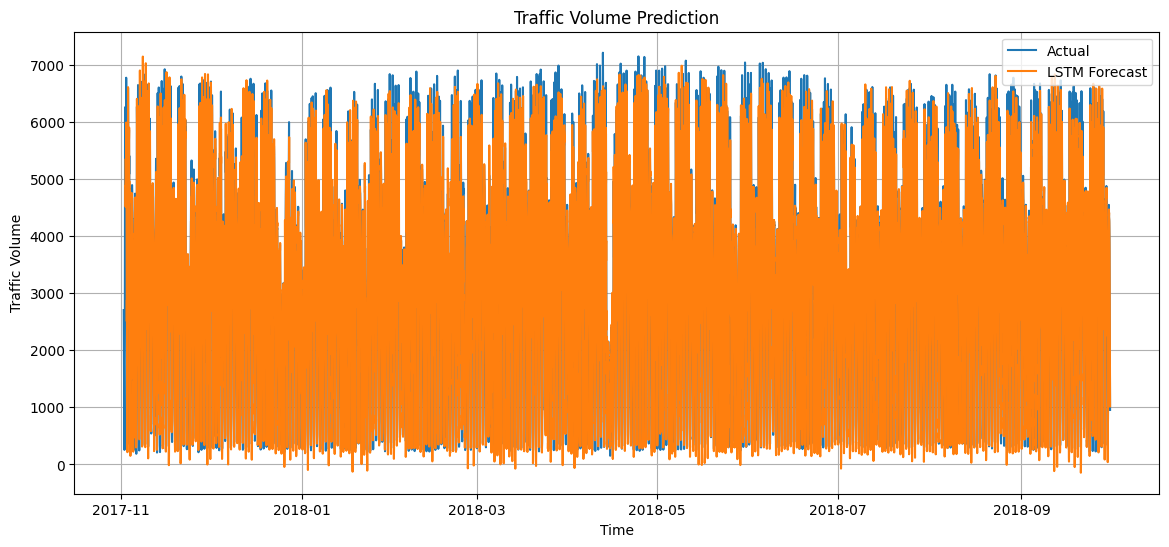

In [ ]:
# Visualisasi Prediksi
plt.figure(figsize=(14,6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index[seq_len:], lstm_preds_inv.flatten(), label='LSTM Forecast')
plt.legend()
plt.title('Traffic Volume Prediction')
plt.xlabel('Time')
plt.ylabel('Traffic Volume')
plt.grid(True)
plt.show()

Grafik pertama menampilkan perbandingan antara volume lalu lintas aktual dan hasil prediksi model LSTM selama periode sekitar satu tahun. Secara umum, model mampu menangkap pola jangka panjang, tetapi tidak selalu mampu merepresentasikan lonjakan atau penurunan tajam dalam volume lalu lintas. Oleh karena itu, evaluasi kuantitatif RMSE atau MAE sangat diperlukan untuk menilai performa secara lebih objektif.

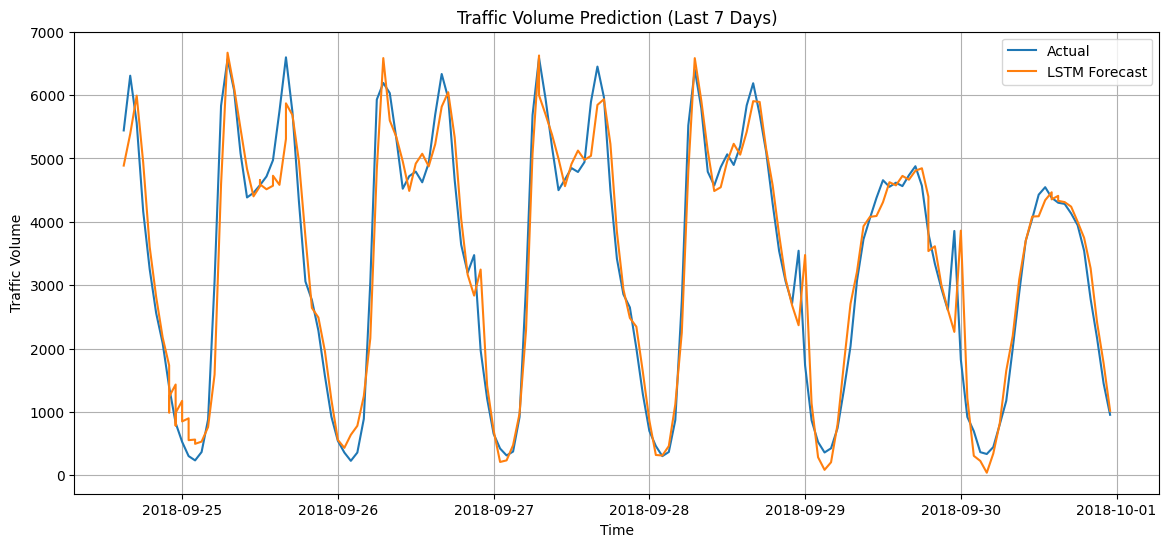

In [ ]:
# Ambil subset data untuk diperjelas
plot_len = 24 * 7  # 7 hari
subset_index = -plot_len

plt.figure(figsize=(14,6))
plt.plot(y_test_trimmed.index[subset_index:], y_test_trimmed_np[subset_index:], label='Actual')
plt.plot(y_test_trimmed.index[subset_index:], lstm_preds_inv_flat[subset_index:], label='LSTM Forecast')
plt.legend()
plt.title('Traffic Volume Prediction (Last 7 Days)')
plt.xlabel('Time')
plt.ylabel('Traffic Volume')
plt.grid(True)
plt.show()

Dalam rentang waktu tujuh hari terakhir, model LSTM univariate menunjukkan hasil prediksi yang sangat baik dengan pola prediksi yang mengikuti tren aktual secara akurat. Pola harian yang menunjukkan lonjakan di siang hari dan penurunan pada malam hari berhasil ditangkap dengan baik oleh model. Meskipun terdapat beberapa deviasi kecil, perbedaannya tidak signifikan.
Secara keseluruhan, model LSTM univariate menunjukkan performa yang cukup baik terutama untuk prediksi jangka pendek. Namun, karena model ini hanya menggunakan satu variabel, performanya bisa menurun apabila terjadi perubahan mendadak yang dipengaruhi oleh faktor eksternal seperti cuaca, hari libur, atau event khusus. Oleh karena itu, penggunaan model multivariate yang mempertimbangkan lebih banyak fitur berpotensi memberikan hasil yang lebih akurat untuk prediksi jangka menengah hingga panjang.

## LSTM Multivariate Modeling

In [ ]:
# LSTM Multivariate Modeling
features = ['traffic_volume', 'hour', 'dayofweek', 'is_weekend'] + \
           [col for col in df.columns if col.startswith('weather_main_') or col.startswith('holiday_')]

scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(df_train[features])
scaled_test = scaler.transform(df_test[features])

In [ ]:
# Buat dataset LSTM
def create_sequences_multivariate(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length][0])  # traffic_volume
    return np.array(X), np.array(y)

seq_len = 24
X_train, y_train_lstm = create_sequences_multivariate(scaled_train, seq_len)
X_test, y_test_lstm = create_sequences_multivariate(scaled_test, seq_len)

In [ ]:
# Build improved model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(seq_len, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Train model
model.fit(X_train, y_train_lstm, epochs=30, batch_size=64, verbose=1)

Epoch 1/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 0.0477
Epoch 2/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0138
Epoch 3/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0100
Epoch 4/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0085
Epoch 5/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0078
Epoch 6/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0070
Epoch 7/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0069
Epoch 8/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0065
Epoch 9/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0062
Epoch 10/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0062
Epoch 11/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0059
Epoch 12/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0056
Epoch 13/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0055
Epoch 14/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0056
Epoch 15/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - 

In [ ]:
# Predict dan inverse transform
lstm_preds = model.predict(X_test)
# Ambil hanya kolom traffic_volume untuk inverse transform
traffic_index = features.index('traffic_volume')
y_test_inv = scaler.inverse_transform(np.concatenate([y_test_lstm.reshape(-1,1), X_test[:, -1, 1:]], axis=1))[:, 0]
lstm_preds_inv = scaler.inverse_transform(np.concatenate([lstm_preds, X_test[:, -1, 1:]], axis=1))[:, 0]

mae_lstm, rmse_lstm, mape_lstm = evaluate(y_test_inv, lstm_preds_inv)
print(f'LSTM Multivariate MAE: {mae_lstm:.2f}, RMSE: {rmse_lstm:.2f}, MAPE: {mape_lstm:.2f}%')

301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
LSTM Multivariate MAE: 245.55, RMSE: 366.85, MAPE: 12.56%


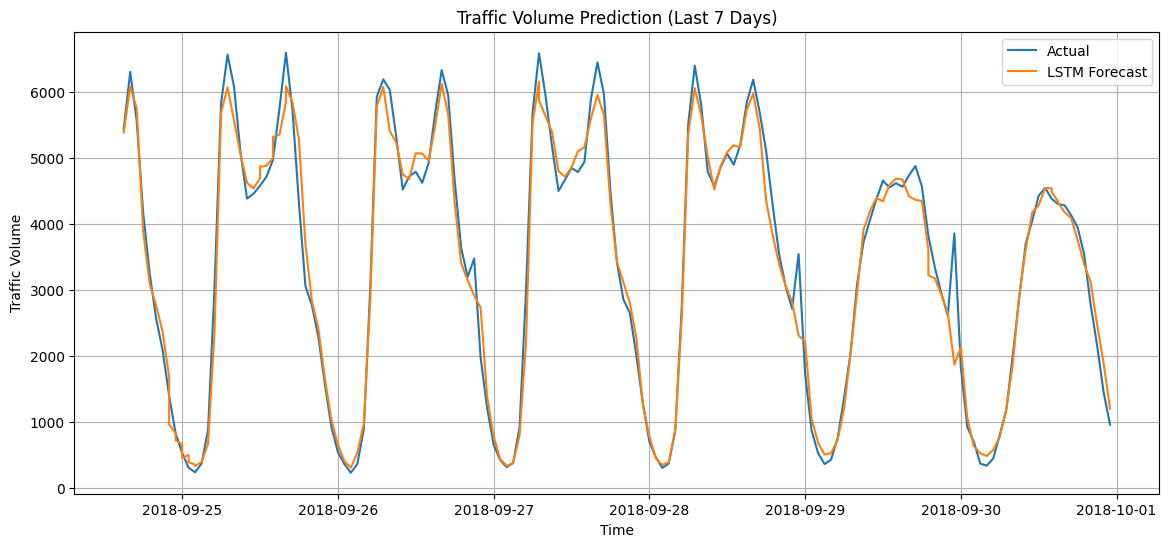

In [ ]:
# Visualisasi Prediksi Subset
plot_len = 24 * 7  # 7 hari terakhir
subset_index = -plot_len

plt.figure(figsize=(14,6))
plt.plot(df_test.index[seq_len:][subset_index:], y_test_inv[subset_index:], label='Actual')
plt.plot(df_test.index[seq_len:][subset_index:], lstm_preds_inv[subset_index:], label='LSTM Forecast')
plt.legend()
plt.title('Traffic Volume Prediction (Last 7 Days)')
plt.xlabel('Time')
plt.ylabel('Traffic Volume')
plt.grid(True)
plt.show()

Dalam grafik ini, terlihat bahwa model mampu menangkap pola fluktuasi harian dengan cukup baik. Garis oranye yang mewakili prediksi model LSTM hampir selalu mengikuti pergerakan garis biru yang merepresentasikan data aktual. Pola naik-turun volume lalu lintas yang terjadi secara konsisten setiap hari—kemungkinan mencerminkan aktivitas harian seperti jam sibuk pagi dan sore—berhasil direkonstruksi oleh model.

Kinerja model multivariate terlihat stabil dan presisi dalam mendeteksi puncak maupun lembah lalu lintas harian, termasuk saat terjadi perubahan mendadak. Beberapa deviasi kecil memang masih terjadi, terutama saat prediksi sedikit tertinggal atau mendahului nilai aktual, namun perbedaannya tidak signifikan secara keseluruhan. Hal ini menunjukkan bahwa penambahan variabel lain seperti waktu, hari dalam seminggu, cuaca, membantu model untuk memahami konteks pola lalu lintas dengan lebih baik dibandingkan model univariate.

### Save model

Model LSTM yang telah dilatih dan objek normalisasi (scaler) disimpan untuk digunakan kembali saat prediksi.

In [ ]:
model.save('lstm_multivariate_traffic_model.h5')

In [ ]:
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

## Prediksi 24 jam ke depan

Menggunakan model LSTM multivariat yang telah disimpan untuk melakukan prediksi volume lalu lintas selama 24 jam ke depan berdasarkan data 24 jam terakhir.

In [ ]:
# Load model
model = load_model('lstm_multivariate_traffic_model.h5', compile=False)

# Load scaler (jika kamu menyimpannya dengan pickle)
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Ambil 24 jam terakhir dari dataset df
last_24_hours = df.iloc[-24:]

# Ambil hanya kolom fitur yang digunakan saat training LSTM
# Gunakan list 'features' untuk memilih kolom dari DataFrame last_24_hours
X_input = last_24_hours[features]

# Normalisasi menggunakan scaler yang sama
X_input_scaled = scaler.transform(X_input)

# Bentuk [samples, timesteps, features]
X_input_scaled = X_input_scaled.reshape((1, 24, X_input_scaled.shape[1]))

# Menyimpan hasil prediksi
future_predictions = []

current_input = X_input_scaled.copy()

for i in range(24):  # Prediksi 24 langkah ke depan
    # Prediksi langkah
    next_pred_scaled = model.predict(current_input)[0][0]

    # Simpan hasil prediksi dalam skala normal
    future_predictions.append(next_pred_scaled)

    # geser window dan tambahkan prediksi baru
    # Karena hanya prediksi 1 output, replikasi input lainnya dari jam terakhir
    next_features = current_input[0, -1, :].copy()
    next_features[0] = next_pred_scaled

    # Tambahkan fitur baru ke window input
    current_input = np.append(current_input[:, 1:, :], [[next_features]], axis=1)

# Invers transform hasil prediksi
predicted_traffic_volume = scaler.inverse_transform(
    np.column_stack((future_predictions, np.zeros((24, X_input.shape[1]-1))))
)[:, 0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


### Visualisasi prediksi
Menampilkan hasil prediksi lalu lintas selama 24 jam ke depan dibandingkan dengan 48 jam terakhir yang aktual.

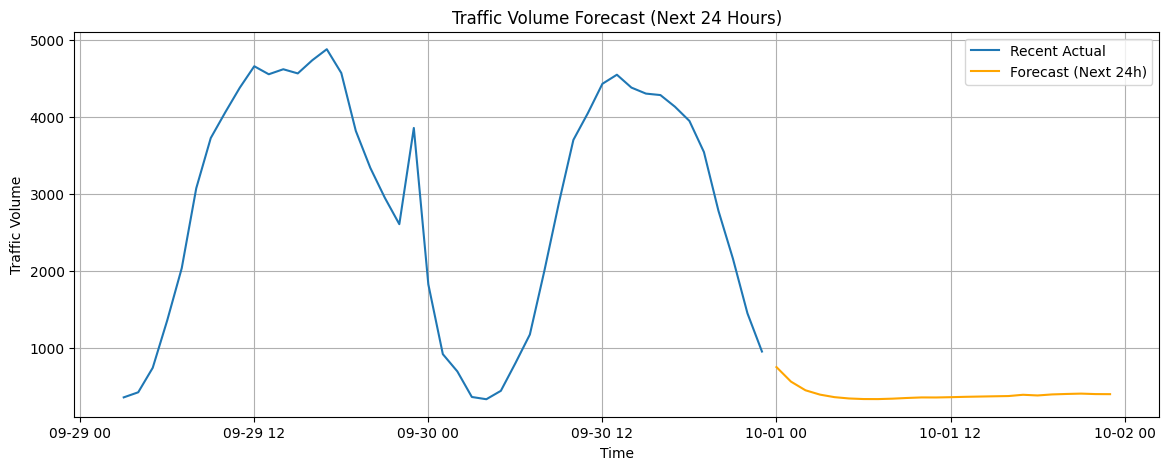

In [ ]:
# Waktu mulai prediksi = 1 jam setelah timestamp terakhir
last_timestamp = df.index[-1]
future_timestamps = [last_timestamp + pd.Timedelta(hours=i+1) for i in range(24)]

plt.figure(figsize=(14,5))
plt.plot(df.index[-48:], df['traffic_volume'].iloc[-48:], label='Recent Actual')
plt.plot(future_timestamps, predicted_traffic_volume, label='Forecast (Next 24h)', color='orange')
plt.legend()
plt.title('Traffic Volume Forecast (Next 24 Hours)')
plt.xlabel('Time')
plt.ylabel('Traffic Volume')
plt.grid(True)
plt.show()


Model Long Short-Term Memory (LSTM) berhasil dikembangkan untuk memprediksi volume lalu lintas berdasarkan data historis dan variabel waktu, kondisi cuaca, dan hari libur. Setelah melalui proses praproses data, eksplorasi, dan normalisasi fitur, model LSTM dilatih dengan pendekatan multivariat dan mampu memberikan hasil prediksi yang cukup akurat. Evaluasi model menunjukkan performa yang baik dengan nilai MAE, RMSE, dan MAPE yang relatif rendah, terutama setelah peningkatan jumlah epoch dan penggunaan fitur yang lebih lengkap. Selain itu, model yang telah dilatih juga dapat digunakan untuk memprediksi volume lalu lintas 24 jam ke depan secara otomatis, menunjukkan potensi penggunaan dalam sistem pemantauan lalu lintas atau pengambilan keputusan transportasi. LSTM terbukti efektif dalam menangkap pola temporal yang kompleks dalam data lalu lintas dan memberikan prediksi yang dapat diandalkan.